# Learning the sine function with QML

In this task we optimize a variational circuit to *learn* the sine function. Given a training dataset with $n$ points $x_1, \ldots, x_n \in [0, 2\pi]$ and targets $\sin(x_1), \ldots, \sin(x_n)$, optimize a variational circuit $U(x, \vec{\theta })$ such that the expected value of a suitable observable $\hat{M}$ approximates the $\sin$ function, i.e., 
$$
\sin(x) \approx \langle 0 | U(x, \vec{\theta})^\dag \hat{M} U(x, \vec{\theta}) | 0 \rangle.
$$ 
As we saw in Task 2, the circuit usually depends on the input data $x$ only at the beginning through the data encoding. For this task we use *angle encoding*, as the argument of the $\sin$ function is an angle.

We do the necessary imports.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt

In the following code, we construct the training dataset consisting of 10 equally spaced points in $[0, 2\pi]$ and evaluate the $\sin$ function at those points.

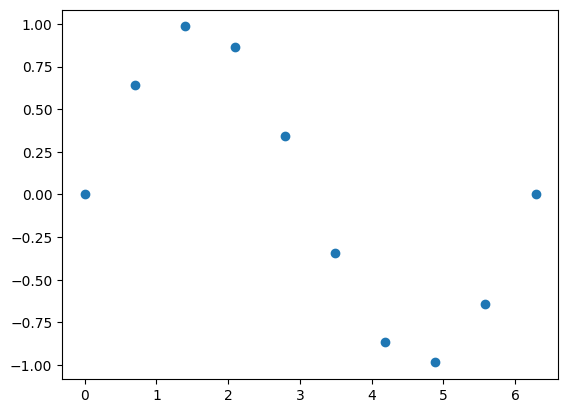

In [2]:
n_points = 10
x = np.linspace(0, 2*np.pi, n_points, requires_grad=False)
y = np.sin(x)
plt.scatter(x, y)
plt.show()

Then, we create the quantum device (a simulator) where the quantum circuits will be executed.

In [3]:
dev = qml.device("default.qubit", wires=1)

The variational circuit uses 1 qubit with angle encoding, which is implemented using an $RX$, and one layer consisting of a $RY$ gate followed by a $RX$ gate. The parameters of these rotation gates in the layer are determined through an optimization method, and the parameter for the $RX$ rotation in the angle encoding is just the input data. The circuit diagram is shown below.

The suitable observable for this task is the $Z$ observable. Recall that the eigenvalues of $Z$ are $1$ and $-1$, and the corresponding eigenvectors are $|0\rangle$ and $|1\rangle$, respectively. So the expected value of a $Z$ measurement, given a qubit state $|\psi\rangle = a|0\rangle + b|1\rangle$, is
$$
\langle \psi | Z |\psi \rangle = |a|^2(1) + |b|^2(-1),
$$
which lies in $[-1,1]$ since it is a convex combination of -1 and 1 (recall $|a|^2 + |b|^2 = 1$). This makes the $Z$ observable ideal to learn the $\sin$ function with values also in $[-1, 1]$.

In [4]:
def layer(layer_weight: np.tensor):
    """Layer consisting of a RY gate followed by a $RX$ gate with parameters given by the tensor layer_weights of size (n, 3), where n is the number of qubits.
    layer_weights[i] correspond to the 3 parameters for the arbitrary rotation applied to qubit i.

    :param layer_weights: Tensor of size (n, 3), where n is the number of qubits.
    :type layer_weights: np.tensor
    """
    qml.RY(layer_weight[0], wires=0)
    qml.RX(layer_weight[1], wires=0)
        
        
def state_preparation(x: np.tensor):
    qml.RX(x, wires=0)


@qml.qnode(dev)
def circuit(weights: np.tensor, x: np.tensor):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

Matplotlib is building the font cache; this may take a moment.


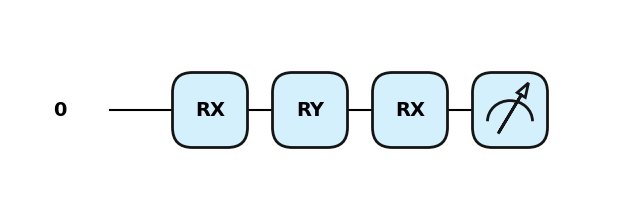

In [5]:
np.random.seed(0)
num_layers = 1
weights_init = np.random.randn(num_layers, 2, requires_grad=True)
qml.draw_mpl(circuit, style="pennylane")(weights_init, 0)
plt.show()

The cost function we use for the optimization problem is the mean squared error of the predictions and the target values. We use the Nesterov-Momentum method and 100 iterations.

In [6]:
def mse(target: np.tensor, predictions: np.tensor) -> float:
    return np.mean((predictions-target)**2)

def cost(weights: np.tensor, x: np.tensor, y: np.tensor) -> float:
    # return the MSE (mean squared error) of the regression model (the circuit)
    predictions = np.array([circuit(weights, xi) for xi in x])
    
    return mse(y, predictions)

In [7]:
opt = NesterovMomentumOptimizer(0.5) # step size of 0.5
num_iters = 100

In [8]:
weights = weights_init

for it in range(num_iters):
    weights = opt.step(cost, weights, x=x, y=y)
    
    if (it+1) % 10 == 0:
        # Compute MSE
        predictions = np.array([circuit(weights, xi) for xi in x])

        current_cost = cost(weights, x, y)
        error = mse(y, predictions)

        print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Error: {error:0.7f}")

Iter:   10 | Cost: 0.0030106 | Error: 0.0030106
Iter:   20 | Cost: 0.0023114 | Error: 0.0023114
Iter:   30 | Cost: 0.0000919 | Error: 0.0000919
Iter:   40 | Cost: 0.0000010 | Error: 0.0000010
Iter:   50 | Cost: 0.0000183 | Error: 0.0000183
Iter:   60 | Cost: 0.0000127 | Error: 0.0000127
Iter:   70 | Cost: 0.0000048 | Error: 0.0000048
Iter:   80 | Cost: 0.0000017 | Error: 0.0000017
Iter:   90 | Cost: 0.0000008 | Error: 0.0000008
Iter:  100 | Cost: 0.0000004 | Error: 0.0000004


At the end of the optimization process, we observe a low error in the predictions on the training dataset. The next step is to evaluate whether the model is able to generalize to unseen data. We obtain 500 equally spaced points on $[-2\pi, 2\pi]$, evaluate the variational circuit on those points, and plot the results to compare them with the real values of the $\sin$ function. In the figure below, the predictions are shown in red circles, and the real $\sin$ function is plotted in black. We see that the model was able to learn the $\sin$ function.

In [9]:
x_test = np.linspace(-2*np.pi, 2*np.pi, 500)
y_test = np.sin(x_test)
y_pred = np.array([circuit(weights, xi) for xi in x_test])

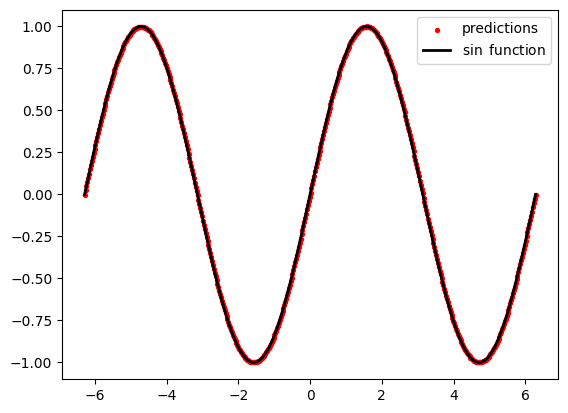

In [10]:
plt.scatter(x_test, y_pred, c="red", s=8, label="predictions")
plt.plot(x_test, y_test, c="black", linewidth=2, label="$\\sin$ function")
plt.legend()
plt.show()